# Upper Grindelwald case study

### Imports
Import the **needed** libs

In [1]:
import numpy as np # fundamental scientific computing package
import pandas as pd # data storage
import netCDF4 # read netCDF files
import scipy.stats as stats #
import salem # geoscientific data processing
import copy # copy operations

In [2]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# show figures in notebook
%matplotlib inline
# set default plot size
fig_size = 12, 6
plt.rcParams['figure.figsize'] = (fig_size)

In [3]:
# oggm modules
import oggm
from oggm import cfg # configuration file and options
from oggm import workflow # wrapper for single task, multi processor handling
from oggm import utils # utility functions
from oggm import graphics # plotting functions
from oggm.core import massbalance, flowline # mass balance and flow line models

In [4]:
# read the default parameter file for OGGM
cfg.initialize()

2018-03-13 15:48:56: oggm.cfg: Parameter file: /Users/oberrauch/Documents/Studium/work/Grindelwald/oggm/oggm/params.cfg


### Glacier directory

In [5]:
# specify path to glacier directory
bdir = '/Users/oberrauch/Documents/Studium/work/Grindelwald/raw_data/grindelwald/'
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)

In [8]:
fls = gdir.read_pickle('geometries.pkl')
flowline.init_present_time_glacier(gdir)

ValueError: geometries.pkl not in cfg.BASENAMES.

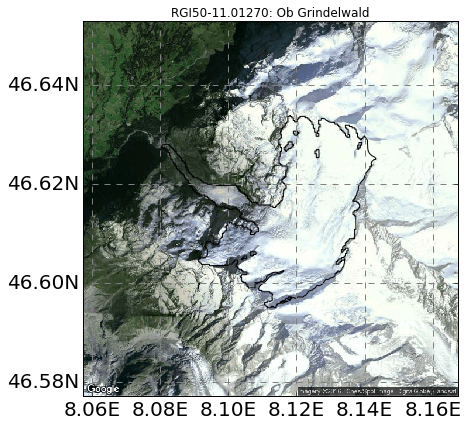

In [28]:
matplotlib.rc('lines', linewidth=1)
graphics.plot_googlemap(gdir)

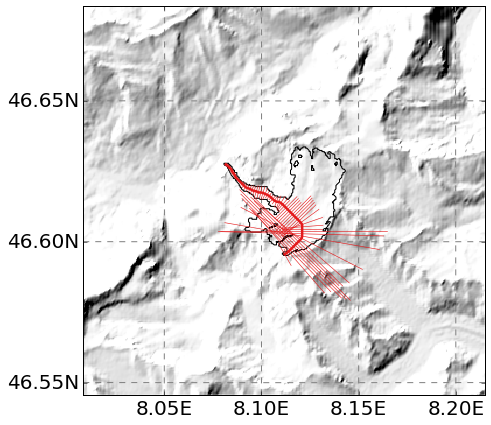

In [29]:
graphics.plot_catchment_width(gdir, corrected=True)

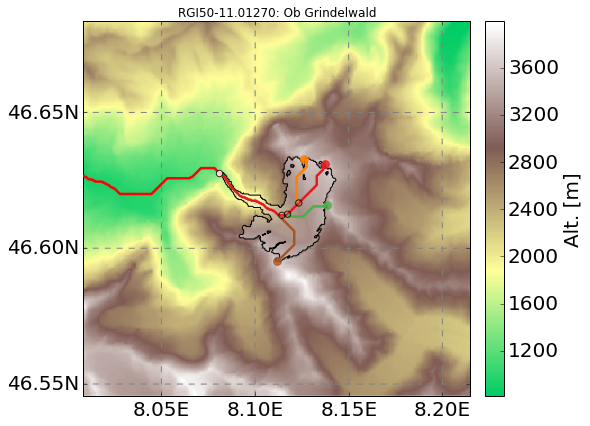

In [30]:
graphics.plot_centerlines(gdir, add_downstream=True)

In [31]:
from __future__ import division
from six.moves import zip

from collections import OrderedDict
import warnings
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from matplotlib import transforms
import matplotlib.colors as colors
from matplotlib.ticker import NullFormatter

from descartes import PolygonPatch
import shapely.geometry as shpg
import glob
import os
import numpy as np
import netCDF4
import salem

from oggm.utils import entity_task

import cleo

# Local imports
import oggm.cfg as cfg

# Module logger
log = logging.getLogger(__name__)

nullfmt = NullFormatter()  # no labels

NameError: name 'truncate_colormap' is not defined

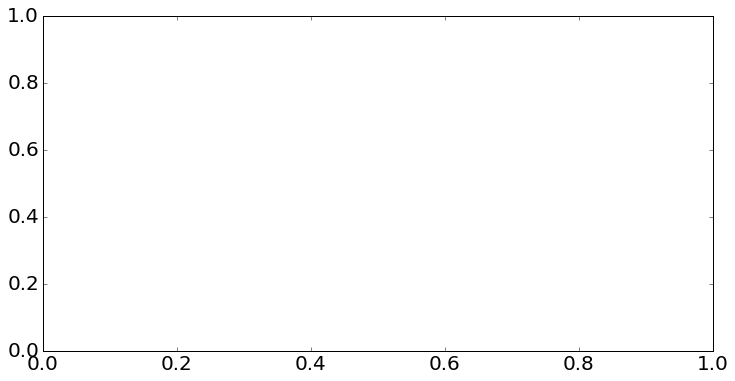

In [32]:
ax=None
use_flowlines=False
add_downstream=True

filename = 'centerlines'
if use_flowlines:
    filename = 'inversion_flowlines'

with netCDF4.Dataset(gdir.get_filepath('gridded_data')) as nc:
    topo = nc.variables['topo'][:]

dofig = False
if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dofig = True

mp = cleo.Map(gdir.grid, countries=False, nx=gdir.grid.nx)
cm = truncate_colormap(colormap.terrain, minval=0.25, maxval=1.0, n=256)
mp.set_cmap(cm)
mp.set_plot_params(nlevels=256)
mp.set_data(topo)

# TODO: center grid or corner grid???
crs = gdir.grid.center_grid

for i in gdir.divide_ids:
    geom = gdir.read_pickle('geometries', div_id=i)

    # Plot boundaries
    poly_pix = geom['polygon_pix']

    mp.set_geometry(poly_pix, crs=crs, fc='white',
                     alpha=0.1, zorder=2, linewidth=0.2)
    for l in poly_pix.interiors:
        mp.set_geometry(l, crs=crs,
                          color='black', linewidth=0.8)

    # plot Centerlines
    cls = gdir.read_pickle(filename, div_id=i)

    # Go in reverse order for red always being the longuest
    cls = cls[::-1]
    color = gpd.plotting.gencolor(len(cls)+1, colormap='Set1')
    for l, c in zip(cls, color):
        mp.set_geometry(l.line, crs=crs, color=c,
                          linewidth=2.5, zorder=50)
        mp.set_geometry(l.head, crs=gdir.grid, marker='o',
                        markersize=60, alpha=0.8, color=c, zorder=99)

        for j in l.inflow_points:
            mp.set_geometry(j, crs=crs, marker='o',
                              markersize=40, edgecolor='k', alpha=0.8,
                              zorder=99, facecolor='none')

    if add_downstream:
        line = gdir.read_pickle('downstream_line', div_id=i)
        mp.set_geometry(line, crs=crs, color='red', linewidth=2.5,
                          zorder=50)

        mp.set_geometry(shpg.Point(line.coords[0]), crs=crs, marker='o',
                              markersize=40, edgecolor='k', alpha=0.8,
                              zorder=99, facecolor='w')



mp.plot(ax)

xlim = [80, 250]
ylim = [80.3, 250][::-1]

ax.set_xlim(xlim)
ax.set_ylim(ylim)


cb = mp.append_colorbar(ax, "right", size="5%", pad=0.2)
cb.set_label('Alt. [m]')
title = gdir.rgi_id
if gdir.name is not None and gdir.name != '':
    title += ': ' + gdir.name
ax.set_title(title)

if dofig:
    plt.tight_layout()
    

(590, 90)

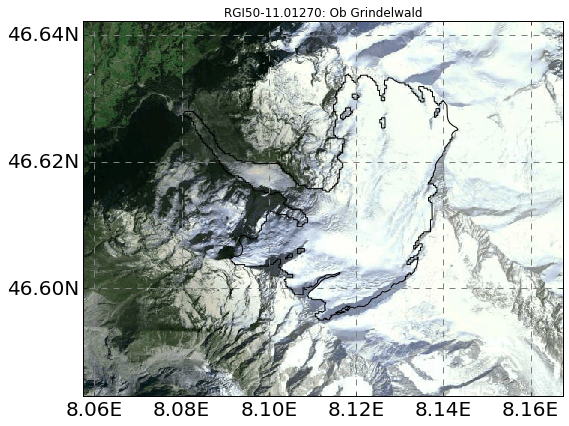

In [33]:
ax = None
crs = gdir.grid.center_grid

dofig = False
if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dofig = True

s = salem.utils.read_shapefile(gdir.get_filepath('outlines'))
gm = salem.GoogleVisibleMap(np.array(s.geometry[0].exterior.xy[0]),
                            np.array(s.geometry[0].exterior.xy[1]),
                            src=s.crs)

img = gm.get_vardata()[..., 0:3]  # sometimes there is an alpha
cmap = cleo.Map(gm.grid, countries=False, nx=gm.grid.nx)
cmap.set_rgb(img)

cmap.set_shapefile(gdir.get_filepath('outlines'))

cmap.plot(ax)
title = gdir.rgi_id
if gdir.name is not None and gdir.name != '':
    title += ': ' + gdir.name
ax.set_title(title)

if dofig:
    plt.tight_layout()
    
ax.set_ylim([590,90])

In [34]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

### By the way, to which year does this glacier outline correspond?  

In [35]:
print(gdir.rgi_date)
print(gdir.rgi_id)

2003-07-01 00:00:00
RGI50-11.01270


### Example: see how well the flowline represents the altitude area distribution of the glacier

In [36]:
# Local topography data
fgrid = gdir.get_filepath('gridded_data')
with netCDF4.Dataset(fgrid) as nc:
    topo = nc.variables['topo_smoothed'][:]
    mask = nc.variables['glacier_mask'][:]

In [37]:
plt.imshow(topo, cmap=truncate_colormap('gist_earth'))
plt.colorbar();

AttributeError: 'str' object has no attribute 'name'

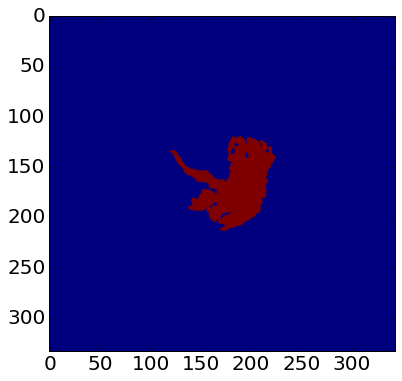

In [38]:
plt.imshow(mask);

In [39]:
(2*3)+(1*6/2)

9.0

In [40]:
# histogram of real glacier
dist_bins = 100
bins = np.arange(1400, 3601, dist_bins)
bins_ = np.arange(1400+dist_bins/2, 3601-dist_bins/2, dist_bins)
hist_real, _ = np.histogram(topo[np.nonzero(mask)], bins=bins, density=True)

In [41]:
# Histogram of flowline glacier
fl = gdir.read_pickle('inversion_flowlines')[-1]  # -1 because there is just one flowline
hist, _ = np.histogram(fl.surface_h, weights=fl.widths, bins=bins, density=True)

In [42]:
# modify plot properties
import matplotlib
matplotlib.rc('lines', linewidth=1.5)

matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=15)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

matplotlib.rc('legend', fontsize=15)
matplotlib.rc('legend', frameon=False)

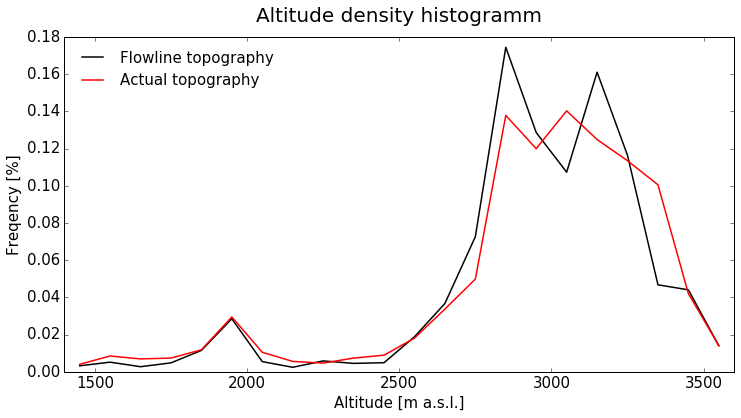

In [43]:
# Plot
plt.plot(bins_, hist*100, label='Flowline topography', color='k')
plt.plot(bins_, hist_real*100, label='Actual topography', color='r')
plt.ylabel('Freqency [%]');
plt.xlabel('Altitude [m a.s.l.]');
plt.xlim([1400,3600])
plt.legend(loc='best');
plt.title('Altitude density histogramm', position=(0.5, 1.03))

In [44]:
import my_colors as mc

NameError: name 'mpatches' is not defined

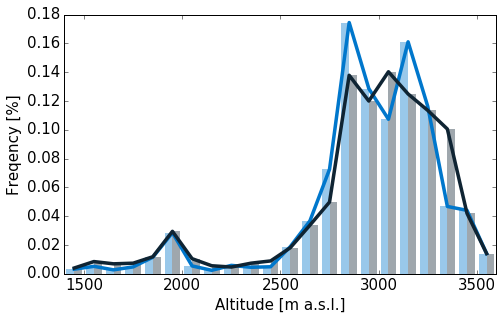

In [45]:
# Plot
#c1 = mc.picton_blue
c1 = c3 = '#0077CC'
c2 = c4 = '#0F2433'

#c3 = '#0077CC'
#c4 = '#0F2433'



fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.5, 0.6])
bar_width = dist_bins/2 * 0.8
bar_offset = dist_bins/2 - bar_width
opacity_bar = 0.4
opacity_line = 1
lw = 3.5
lw_ = 0

plt.bar(bins[:-1]+bar_offset, hist*100, bar_width, 
                        label='Flowline topography', color=c1, 
                        alpha=opacity_bar, lw=lw_)
plt.bar(bins[:-1]+bar_offset+bar_width, hist_real*100, bar_width, 
                     label='Actual topography', 
                     color=c2, alpha=opacity_bar, lw=lw_)

hand, lab = ax.get_legend_handles_labels()

line_1 = plt.plot(bins_, hist*100, label='Flowline topography',
         color=c3, alpha=opacity_line, lw=lw)
line_2 = plt.plot(bins_, hist_real*100, label='Flowline topography',
         color=c4, alpha=opacity_line, lw=lw)

plt.ylabel('Freqency [%]');
plt.xlabel('Altitude [m a.s.l.]');
plt.xlim([1400,3600])

bar_1 = mpatches.Patch(color=c1, alpha=opacity_bar, lw=lw_)
bar_2 = mpatches.Patch(color=c2, alpha=opacity_bar, lw=lw_)
plt.legend([(line_1[0],bar_1),(line_2[0],bar_2)], ['Flowline topography','Actual topography'], loc=2)

# Example: mass-balance data

In [46]:
a = annual_temp.values
b = np.zeros(a.size - 1)
for i, a_ in enumerate(a):
    if not i == b.size:
        b[i] = np.abs(a[i] - a[i+1])

NameError: name 'annual_temp' is not defined

In [47]:
print(b[1:].argmax()+1)
print(b[b[1:].argmin()+1])

NameError: name 'b' is not defined

In [48]:
# modify plot properties
matplotlib.rc('lines', linewidth=3)

t = 20

matplotlib.rc('axes', labelsize=t)

matplotlib.rc('xtick', labelsize=t) 
matplotlib.rc('ytick', labelsize=t)

matplotlib.rc('legend', fontsize=t)
matplotlib.rc('legend', frameon=False)

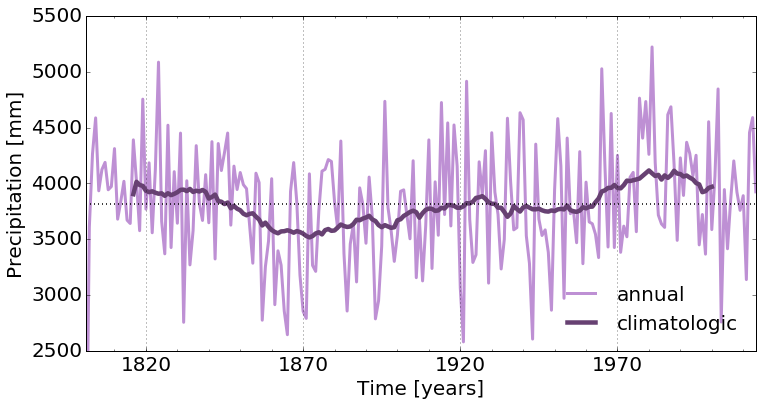

In [13]:
import xarray as xr
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))
annual_prcp = d.prcp.resample(freq='AS', dim='time', how=np.sum).to_series()
ax = annual_prcp.plot(label='annual', color=mc.precip_color_1);
annual_prcp.rolling(30, center=True).mean().plot(label='climatologic', color=mc.precip_color_2, lw=4.5);
ax.set_ylim([2500, 5500]);
plt.axhline(annual_prcp.mean(), color='k', linestyle=':', lw=1.5)
plt.legend(loc=4);
plt.grid(axis='x')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Precipitation [mm]');
#ax.set_title('Annual precipitation from the HISTALP Dataset');

In [49]:
fpath = gdir.get_filepath('climate_monthly')
print(fpath)
nc = netCDF4.Dataset(fpath, mode='r')

/Users/oberrauch/bac/raw_data/grindelwald/RGI50-11.01270/climate_monthly.nc


In [1]:
yr_range = [1983, 2003]
time = nc.variables['time']
time = netCDF4.num2date(time[:], time.units)
ny, r = divmod(len(time), 12)
yrs = np.arange(time[-1].year-ny+1, time[-1].year+1, 1).repeat(12)
p0 = np.min(np.nonzero(yrs == yr_range[0])[0])
p1 = np.max(np.nonzero(yrs == yr_range[1])[0]) + 1

NameError: name 'nc' is not defined

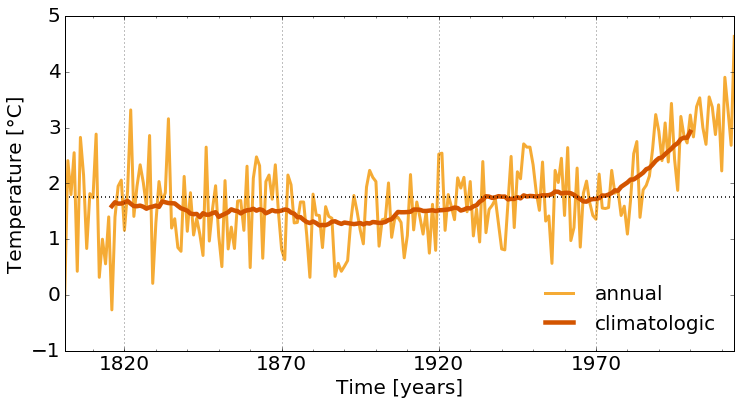

In [51]:
annual_temp = d.temp.resample(freq='AS', dim='time', how=np.mean).to_series()
ax = annual_temp.plot(label='annual',
                      color=mc.temp_color_1);
annual_temp.rolling(30, center=True).mean().plot(label='climatologic',
                                                 color=mc.temp_color_2,
                                                 lw=4.5);
plt.legend(loc=4);
plt.grid(axis='x')
plt.axhline(annual_temp.mean(), c='k', lw=1.5, linestyle=':')
ax.set_xlabel('Time [years]');
ax.set_ylabel('Temperature [°C]');

In [52]:
ind_ = 15;
precip_mean = annual_prcp.rolling(30, center=True).mean()[15:-14]
temp_mean = annual_temp.rolling(30, center=True).mean()[15:-14]
slope, intercept, r_value, p_value, std_err = stats.linregress(
    precip_mean[:-ind_], temp_mean[:-ind_])

r: 0.659022462253995
r^2: 0.4343106057553182


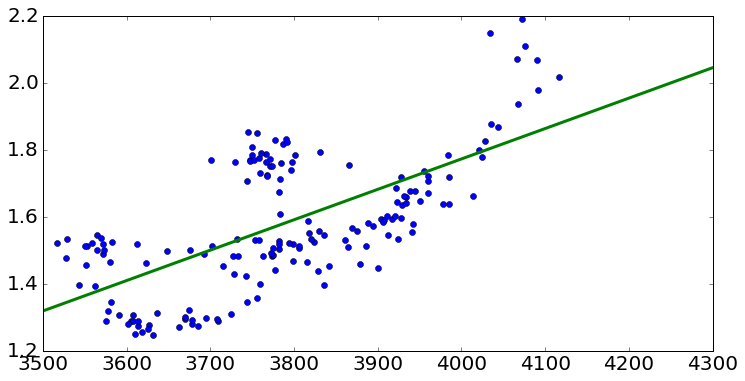

In [53]:
plt.plot(precip_mean[:-ind_], temp_mean[:-ind_], linestyle='none', marker='o')
x = np.linspace(3500, 4300, 100)
y = x * slope + intercept
plt.plot(x,y)
print('r: {}'.format(r_value))
print('r^2: {}'.format(r_value**2))

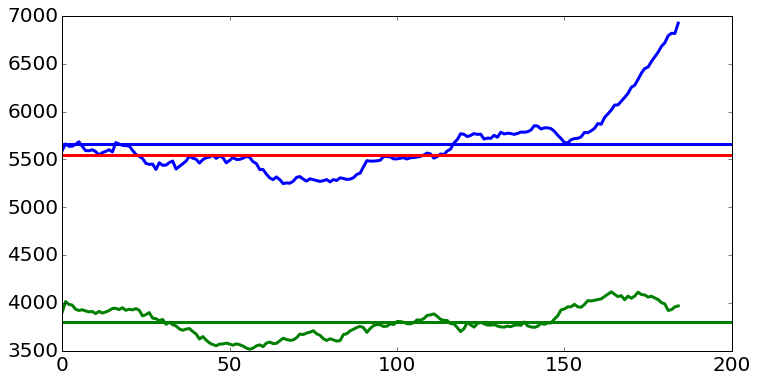

In [54]:
plt.plot(temp_mean.values*1e3+4e3)
plt.axhline((temp_mean.values*1e3+4e3).mean(), color='b')
plt.plot(precip_mean.values)
plt.axhline(precip_mean.values.mean(), color='g')
plt.axhline((temp_mean.values[:-25]*1e3+4e3).mean(), color='r')

In [55]:
# t_Star = year at which Grindelwald was in equi, according to oggm. mu_star is temperature sensitivity
pd.read_csv(gdir.get_filepath('local_mustar'))

rgi_id  t_star     mu_star  bias
0  RGI50-11.01270    1975  256.131565   0.0

In [56]:
# We can build a mass-balance model based on these values and climate from HISTALP
mbmod = massbalance.HistalpMassBalanceModel(gdir)

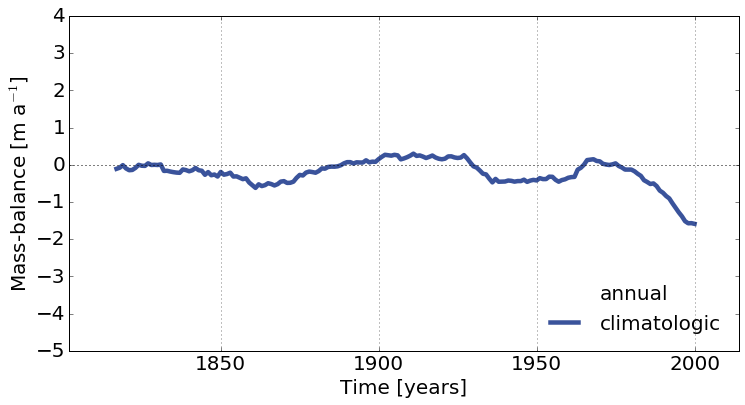

In [57]:
years = np.arange(1802, 2015, 1)
spec_mb = years * 0.
for i, y in enumerate(years):
    mb_onh = mbmod.get_mb(fl.surface_h, year=y) * oggm.cfg.SEC_IN_YEAR
    spec_mb[i] = np.average(mb_onh, weights=fl.widths)
spec_mb = pd.Series(spec_mb, index=years)
ax = spec_mb.plot(label='annual', color=mc.mb_color_1, alpha=0.);
spec_mb.rolling(30, center=True).mean().plot(label='climatologic', color=mc.mb_color_2, lw=4.5);
plt.grid(axis='x')
plt.axhline(0, linestyle=':', color='k', lw=1);
plt.legend(loc=4);
ax.set_xlabel('Time [years]');
ax.set_ylabel('Mass-balance [m a$^{-1}$]');
#ax.set_title('Mass-balance for the Upper Grindelwald Glacier');

In [26]:
# Check that mass balance around 1975 is approx zero
spec_mb.loc[1960:1990].mean()

1.8639282857670485e-07

### Example: length data from Leclercq

This is a dataset provided by Paul Leclercq: http://folk.uio.no/paulwl/data.php.

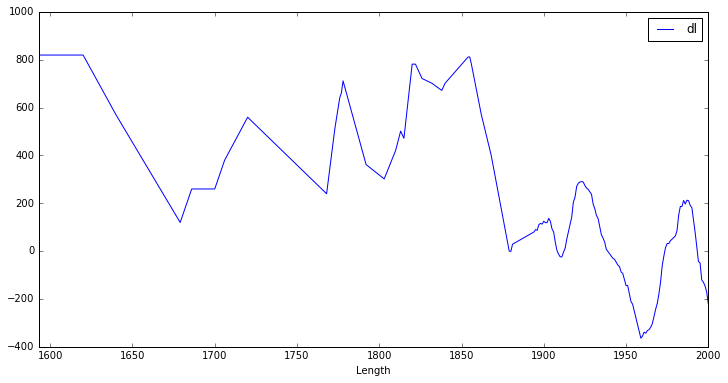

In [27]:
lengths_data = pd.read_csv(utils.get_demo_file('grindelwald_lengths.csv'), index_col=0)
# We plot the entire period:
ax = lengths_data.plot();
ax.set_xlabel('Length');

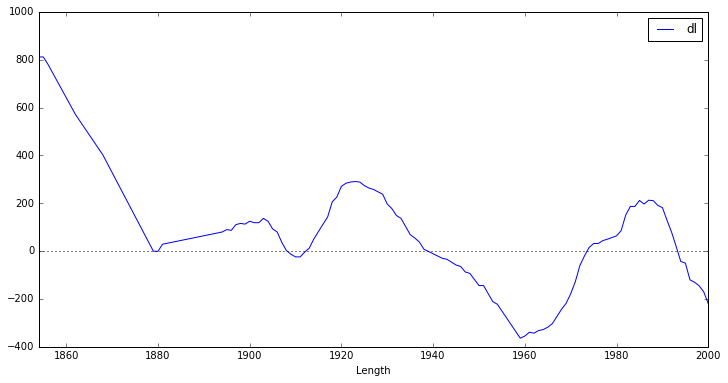

In [28]:
# Plot the last 150 years:
ax = lengths_data.loc[1850:].plot();
ax.set_xlabel('Length');
plt.axhline(0, linestyle=':', color='k');

### Example: compute the bed thickness

In [488]:
from oggm.core.preprocessing.inversion import invert_parabolic_bed

In [489]:
glen_a = cfg.A
vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a)
print('With the default A (={}), the mean thickness of Grindelwald is {:.1f} m'.format(glen_a, vol_m3/area_m3))

With the default A (=2.4e-24), the mean thickness of Grindelwald is 56.4 m


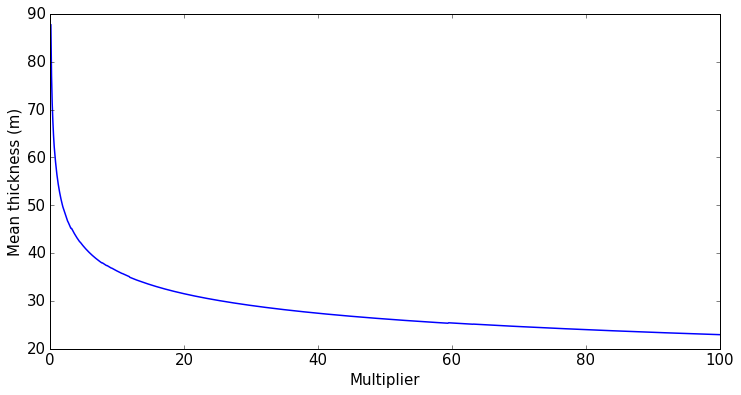

In [492]:
factor = np.linspace(0.1, 100, 1000)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    thick[i] = vol_m3/area_m3
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('Multiplier');

Glens flowline parameter `A` ...

### Try to find out which points corresponds to the location of the GPR measurements (more or less)

Approximate lon, lat of measurements:

In [216]:
lat_ref, lon_ref = 46.617991, 8.098331

Lon, lat along the flowline and closest point (index):

In [217]:
fl

In [221]:
gi, gj = fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)
distances = np.sqrt((lon_ref - lon)**2 + (lat_ref - lat)**2)
index = np.argmin(distances)
print(index)

40


Expected width (from plot by Andreas Bauder): ~ 425 m. Expected thickness: ~ 170 m

473.062643515


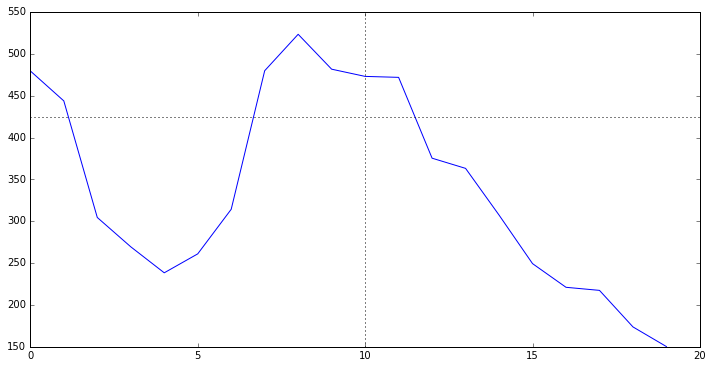

In [219]:
# Plot of the width around the closest point
width_meter = fl.widths * gdir.grid.dx
plt.plot(width_meter[index-10:index+10])
print(width_meter[index])
plt.axhline(425, color='k', linestyle=':')
plt.axvline(10, color='k', linestyle=':')

Ok the the closest point is a good indicator. Let's plot the thickness of our section for several factors:

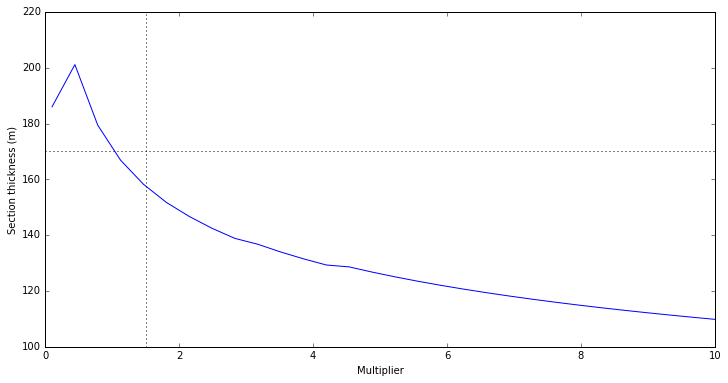

In [220]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    out = gdir.read_pickle('inversion_output', div_id=1)
    thick[i] = out[0]['thick'][index]  
plt.plot(factor, thick);
plt.ylabel('Section thickness (m)');
plt.xlabel('Multiplier');
plt.axhline(170, color='k', linestyle=':')
plt.axvline(1.5, color='k', linestyle=':')

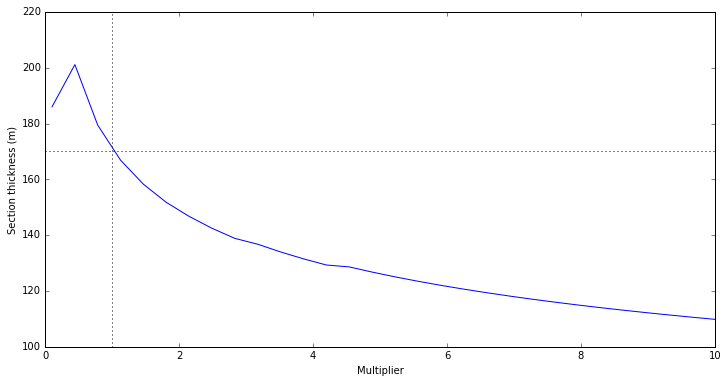

In [222]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    out = gdir.read_pickle('inversion_output', div_id=1)
    thick[i] = out[0]['thick'][index]  
plt.plot(factor, thick);
plt.ylabel('Section thickness (m)');
plt.xlabel('Multiplier');
plt.axhline(170, color='k', linestyle=':')
plt.axvline(1, color='k', linestyle=':')

## Flowline modelling: purely parabolic bed

We are now inverting the ice with a factor 2:

In [176]:
out = invert_parabolic_bed(gdir, glen_a=glen_a*1.5, write=True)

And preparing the data for the run. `init_present_time_glacier` is taking the data from the inversion and makes model flowlines out of it:

In [177]:
# we keep the bed parabolic everywhere, just like for the inversion
cfg.PARAMS['bed_shape'] = 'parabolic'
flowline.init_present_time_glacier(gdir)

We can read the flowline out of the glacier directory:

In [178]:
fls = gdir.read_pickle('model_flowlines')
fl = fls[0]
fl

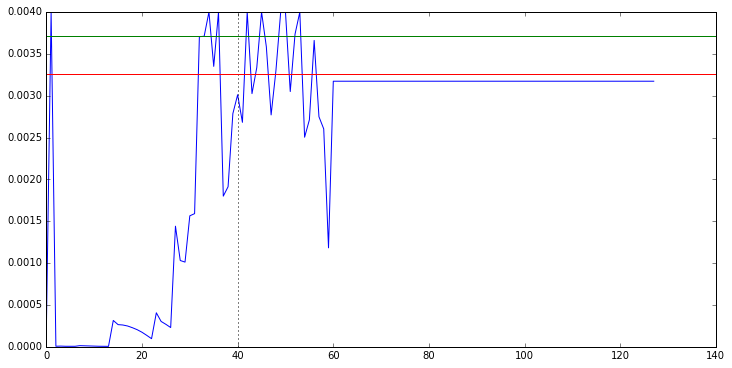

In [179]:
# plot the bed_shape
# it has very low values in the accumulation area, and can have very high values in the tongue
# For the downstream line, the method has picked a standard value
plt.plot(fl.bed_shape);

plt.axvline(40, c='k', ls=':')

plt.axhline(0.00326, c='r')
plt.axhline(0.00371, c='g')

In [180]:
# origin flowline
u_fl = fls[-1]

In [181]:
# now make a model run with today's climate for a 100 years (a so-called "commitment" run)
mb_mod = massbalance.TodayMassBalanceModel(gdir)
# note the call to deepcopy() - this is important! 
model = flowline.FluxBasedModel(copy.deepcopy(u_fl), mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*1.5)
model.run_until(100)

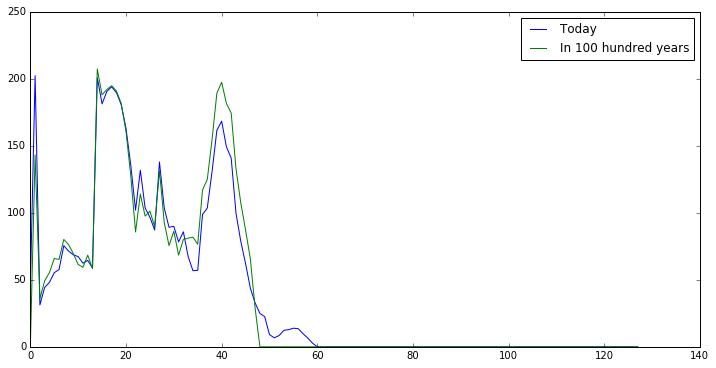

In [182]:
# plot the thickness
plt.plot(u_fl.thick, label='Today')
plt.plot(model.fls[0].thick, label='In 100 hundred years');
plt.legend(loc='best');

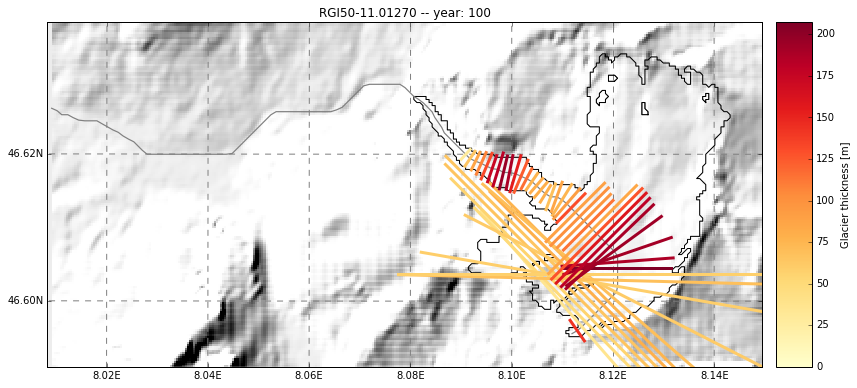

In [61]:
graphics.plot_modeloutput_map(gdir, model=model)

In [62]:
# "BackwardsMassBalanceModel" is a model I developped to help me to grow glaciers
# Here we use it just for illustration
# now add a temperature bias of 2°C to today's climate 
# The bias unit is in hundredths of degree, and of negative sign (sorry for that)
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until_equilibrium()

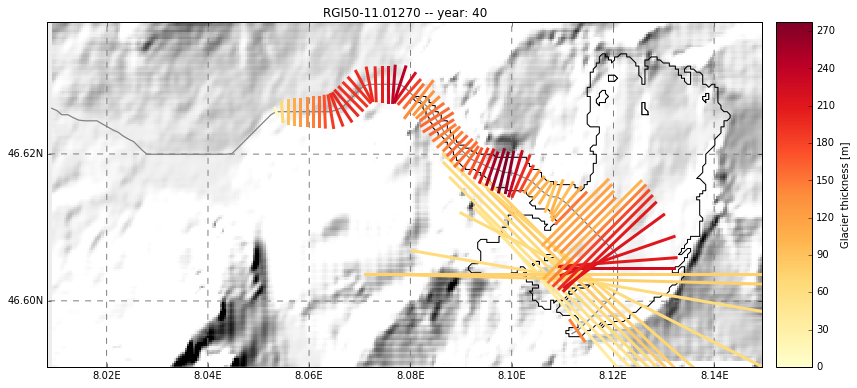

In [63]:
# How does it look like?
graphics.plot_modeloutput_map(gdir, model=model)

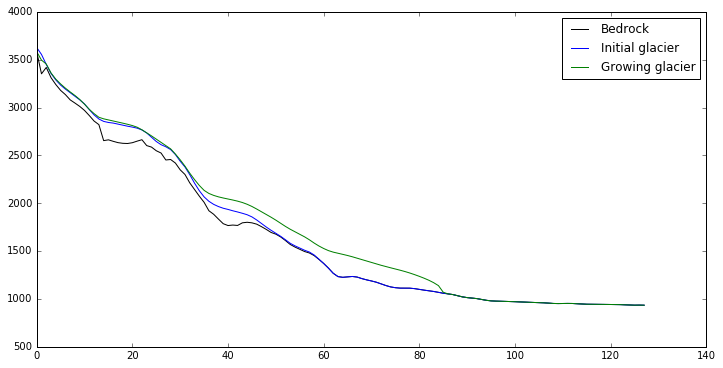

In [65]:
plt.plot(u_fl.bed_h, color='k', label='Bedrock')
plt.plot(u_fl.surface_h, label='Initial glacier')
plt.plot(model.fls[0].surface_h, label='Growing glacier')
#plt.plot(u_fl.bed_shape*1e6)
plt.legend(loc='best');

### Now with real climate forcing

In [190]:
# we now use the actual Histalp mass balance to run the model
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
# Now we are using "real time", so we have to define the starting year accordingly
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)],
                                mb_model=mb_mod, y0=y_start,
                                fs=0., glen_a=glen_a*1.5)

In [191]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m

In [192]:
# add oggm time series to the relative length
ref_data['oggm'] = (length - length[0])

In [193]:
lenght_oggm = np.array(ref_data.oggm.values)
lenght_observed = np.array(ref_data.dl.values)

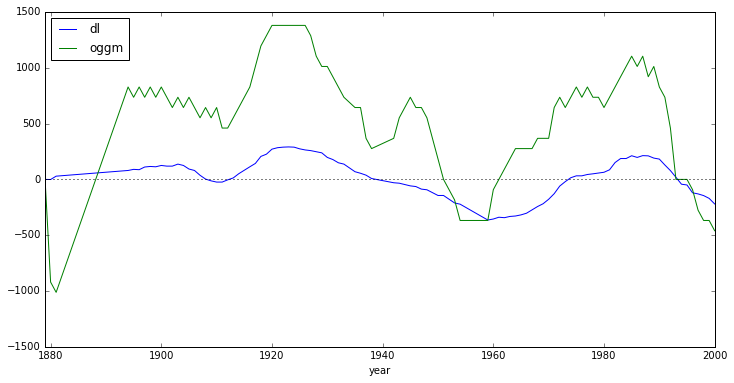

In [194]:
ref_data['oggm'] = lenght_oggm
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

In [317]:
f0 = 0.3
f1 = 0.4

(1879, 2000)

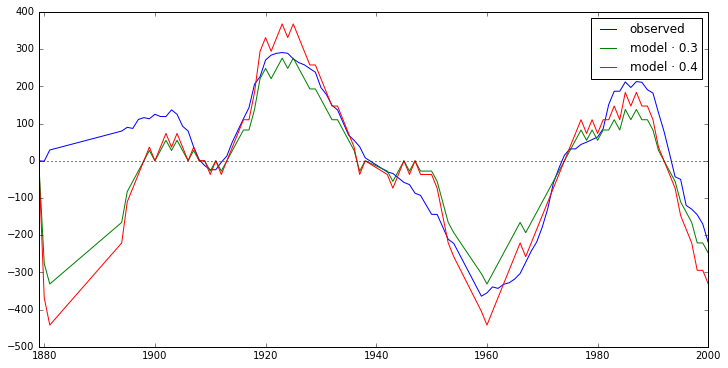

In [318]:
plt.plot(years, lenght_observed, label='observed')
plt.plot(years, lenght_oggm * f0, label='model · {}'.format(f0))
plt.plot(years, lenght_oggm * f1, label='model · {}'.format(f1))
plt.axhline(0, color='k', linestyle=':')
plt.legend(loc='best')
plt.xlim(1879,2000)

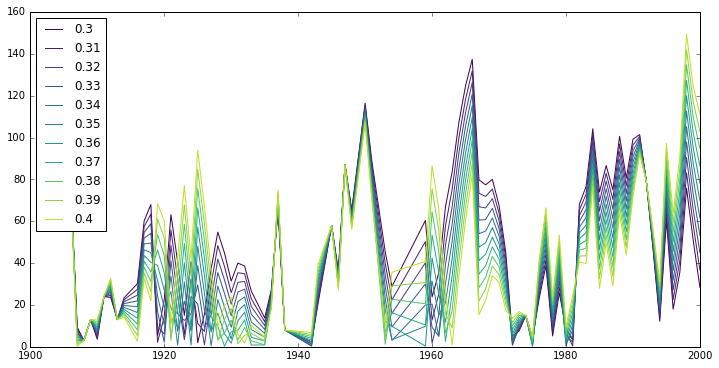

In [319]:
factor = np.arange(f0, f1, 0.01)
n_fac = factor.size;
difs = list()
difs_mean = np.zeros(n_fac)

col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=n_fac)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

start_ = 15
years_ = years[start_:]

for i,f in enumerate(factor):
    col = scalarMap.to_rgba(i)
    dif = abs(lenght_observed - lenght_oggm*f)[start_:]
    dif_mean = np.mean(dif)
    difs.append(dif)
    plt.plot(years_, dif, label=f, color=col)
    difs_mean[i] = dif_mean
plt.axhline(0, color='k', linestyle=':')
plt.legend(loc='best')

In [320]:
ind_err_min = difs_mean.argmin()
fac_min = factor[ind_err_min]
err_min = difs_mean[ind_err_min]
print('Model leght · factor {} = min error {}'.format(round(fac_min,2), round(err_min,2)))

Model leght · factor 0.36 = min error 39.35


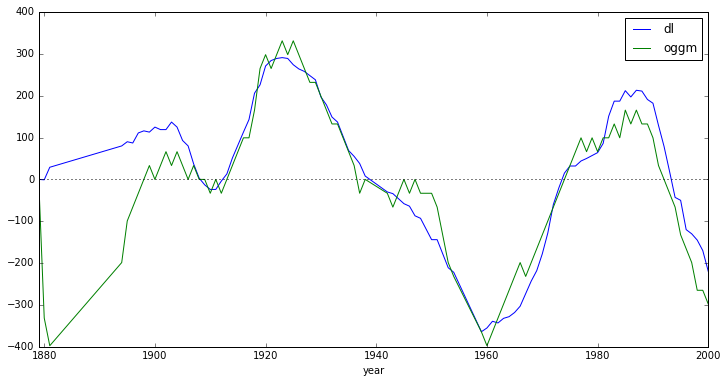

In [321]:
ref_data['oggm'] = lenght_oggm * fac_min
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

Analyse the plot. What is working well, what is not? 

### Now with real climate forcing and with Glen A * 1.5

In [107]:
# we now use the actual Histalp mass balance to run the model
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
# Now we are using "real time", so we have to define the starting year accordingly
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a*1.5)

In [108]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m

In [109]:
# add oggm time series to the relative length
ref_data['oggm'] = (length - length[0])

In [110]:
lenght_oggm = np.array(ref_data.oggm.values)
lenght_observed = np.array(ref_data.dl.values)

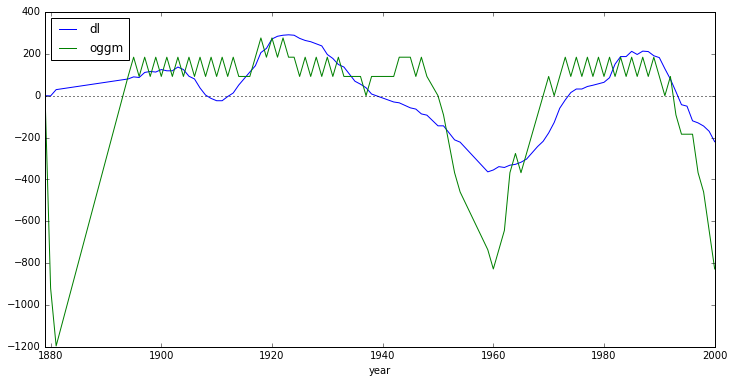

In [106]:
# GLEN A * 1
ref_data['oggm'] = lenght_oggm
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

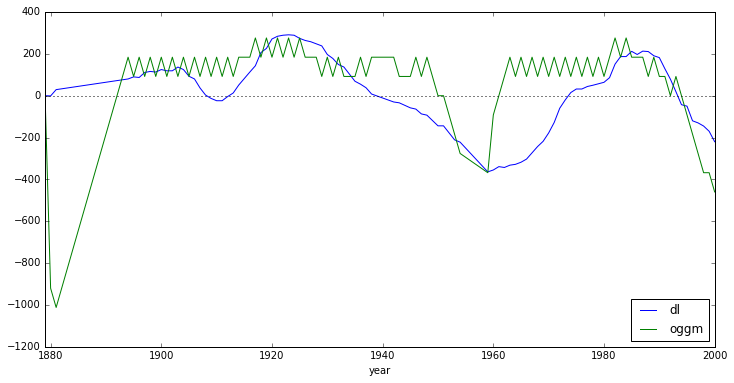

In [111]:
# GLEN A * 1.5
ref_data['oggm'] = lenght_oggm
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

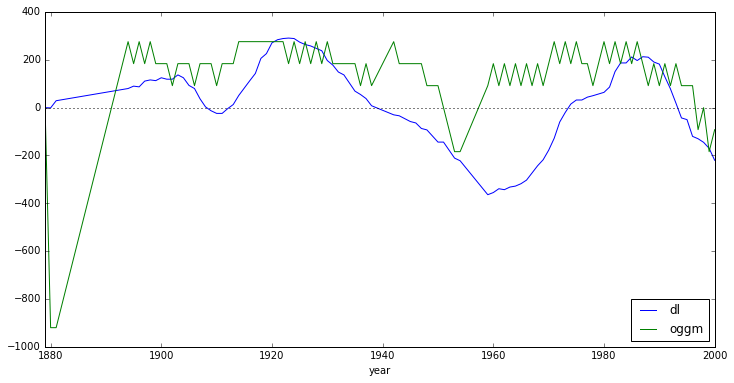

In [101]:
# GLEN A * 2
ref_data['oggm'] = lenght_oggm
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

In [366]:
f0 = 0.2
f1 = 0.5

(1879, 2000)

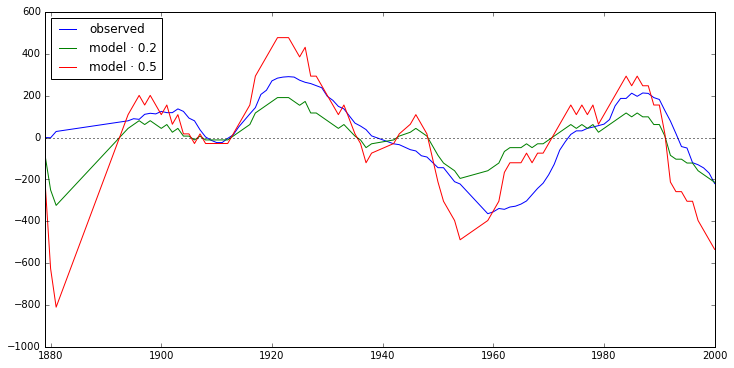

In [374]:
plt.plot(years, lenght_observed, label='observed')
plt.plot(years, (lenght_oggm - d) * f0, label='model · {}'.format(f0))
plt.plot(years, (lenght_oggm - d) * f1, label='model · {}'.format(f1))
plt.axhline(0, color='k', linestyle=':')
plt.legend(loc='best')
plt.xlim(1879,2000)

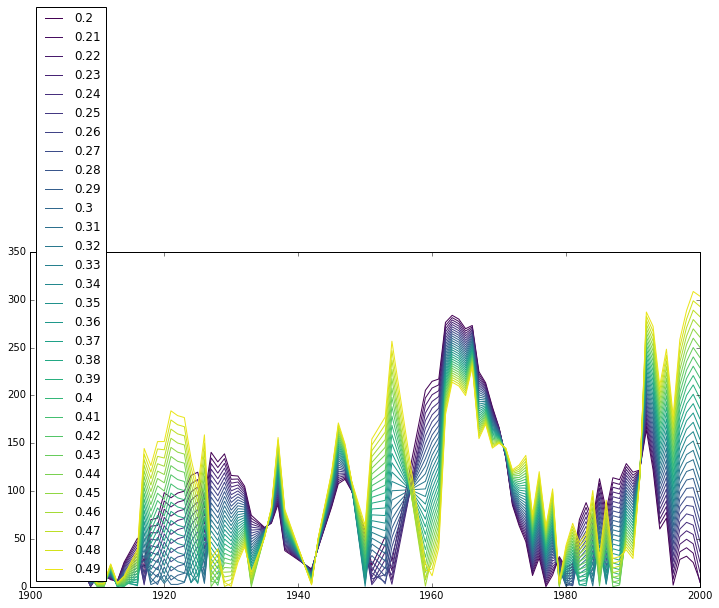

In [379]:
factor = np.arange(f0, f1, 0.01)
n_fac = factor.size;
difs = list()
difs_mean = np.zeros(n_fac)

col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=n_fac)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

start_ = 15
years_ = years[start_:]

for i,f in enumerate(factor):
    col = scalarMap.to_rgba(i)
    dif = abs(lenght_observed - (lenght_oggm - d)*f)[start_:]
    dif_mean = np.mean(dif)
    difs.append(dif)
    plt.plot(years_, dif, label=f, color=col)
    difs_mean[i] = dif_mean
plt.axhline(0, color='k', linestyle=':')
plt.legend(loc='best')

In [380]:
ind_err_min = difs_mean.argmin()
fac_min = factor[ind_err_min]
err_min = difs_mean[ind_err_min]
print('Model leght · factor {} = min error {}'.format(round(fac_min,2), round(err_min,2)))

Model leght · factor 0.3 = min error 79.36


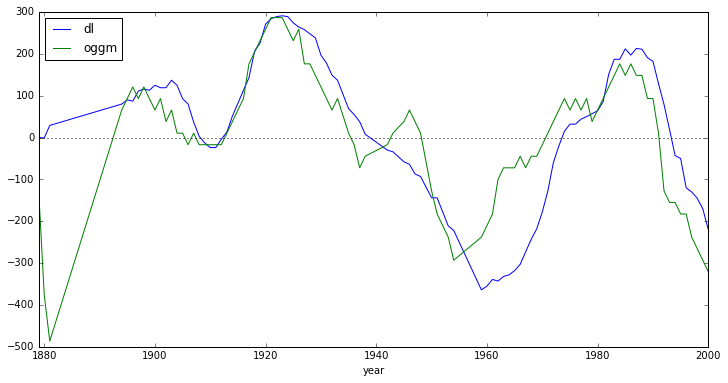

In [382]:
ref_data['oggm'] = (lenght_oggm - d) * fac_min
# Make a plot of it
ref_data.plot();
plt.axhline(0, linestyle=':', color='k');

### Now we change the bed shape after the tongue to make it flat 

In [446]:
fls[-1].bed_shape

array([  1.58542511e-04,   4.00000000e-03,   6.31836784e-06,
         7.95929591e-06,   5.89190464e-06,   6.09129915e-06,
         5.73518188e-06,   1.28677752e-05,   1.11037445e-05,
         9.76881393e-06,   8.80902503e-06,   6.16522584e-06,
         5.88841484e-06,   4.99361098e-06,   2.97195405e-04,
         2.50190294e-04,   2.45873899e-04,   2.34519520e-04,
         2.15282911e-04,   1.92936967e-04,   1.64155192e-04,
         1.28916837e-04,   9.15920107e-05,   3.83652250e-04,
         2.86055375e-04,   2.53410581e-04,   2.17241080e-04,
         1.36041195e-03,   9.73423738e-04,   9.55414642e-04,
         1.47748914e-03,   1.50192083e-03,   3.49802732e-03,
         3.50262963e-03,   3.79839988e-03,   3.16298649e-03,
         4.00000000e-03,   1.69945793e-03,   1.80559989e-03,
         2.63001264e-03,   2.84309118e-03,   2.53190407e-03,
         3.91938880e-03,   2.85587201e-03,   3.14897723e-03,
         4.00000000e-03,   3.38432749e-03,   2.61549361e-03,
         3.11219314e-03,

In [168]:
# Make it flat
u_fl = copy.deepcopy(fls[-1])
u_fl.bed_shape[60] = 5e-5
u_fl.bed_shape[61] = 4e-5
u_fl.bed_shape[62] = 3e-5
u_fl.bed_shape[63] = 2e-5
u_fl.bed_shape[64:] = 1e-5
#u_fl.bed_shape[65:] = 1e-5
u_fl.bed_shape.size

128

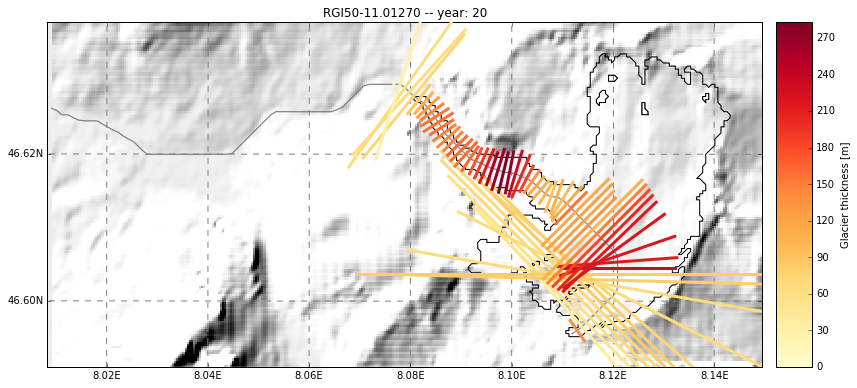

In [169]:
# See how a bigger glacier looks like
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*1.5)
model.run_until_equilibrium()
graphics.plot_modeloutput_map(gdir, model=model)

In [170]:
# we now use the actual Histalp mass balance to run the model on the flat tongue
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a*1.5)

In [171]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m

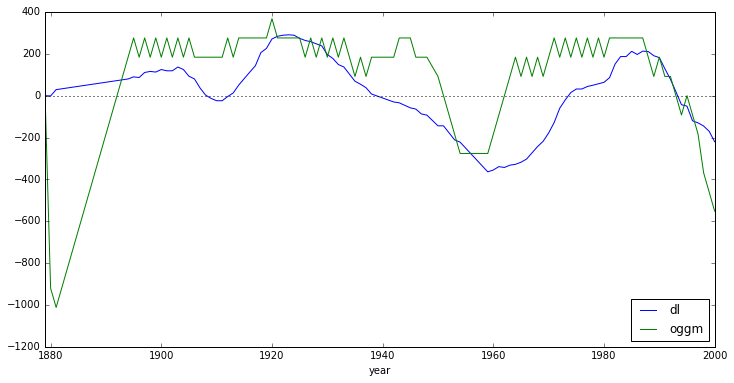

In [172]:
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

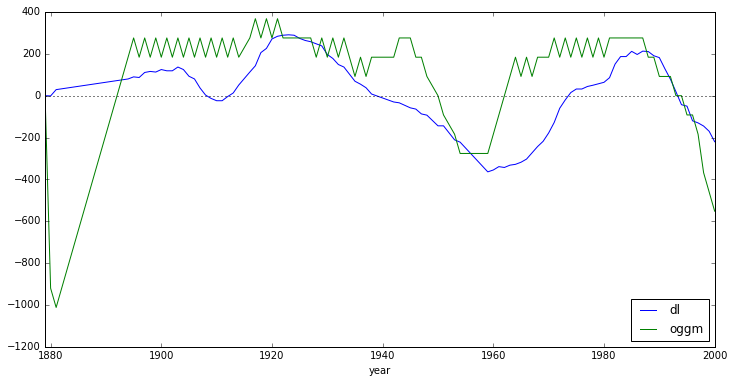

In [167]:
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

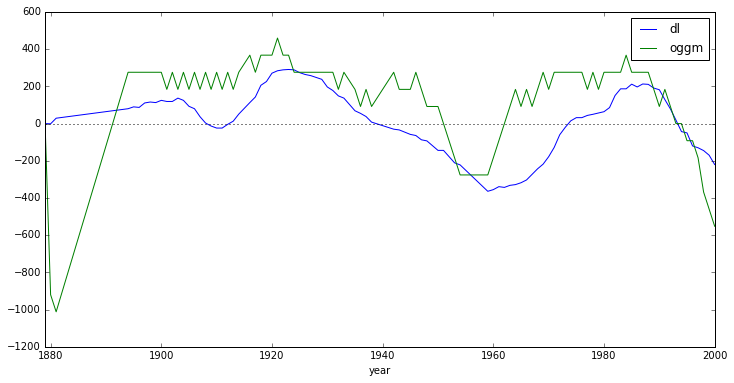

In [147]:
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

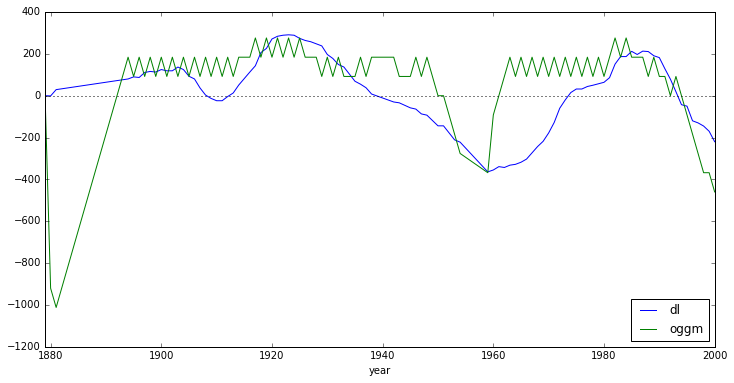

In [126]:
# u_fl.bed_shape[60:] = 1e-5

# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

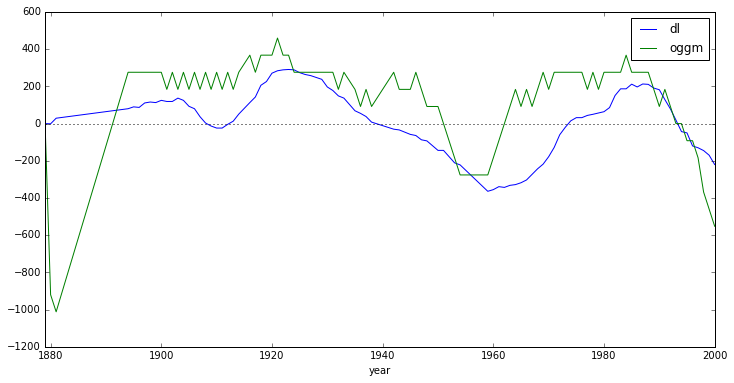

In [121]:
# u_fl.bed_shape[60:] = 1e-4

# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

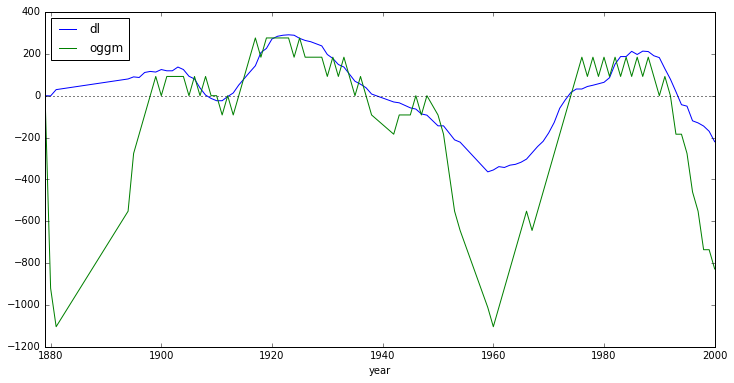

In [430]:
# Fabien's original (Glen_a * 1)
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();
plt.axhline(0, color='k', linestyle=':')

Ok so now we have very realistic advances, but very strong retreats. What could be the reason(s)?

## U-shaped glacier 

the results of the parabolic glacier are actually quite good, but let's try a u shaped glacier for fun

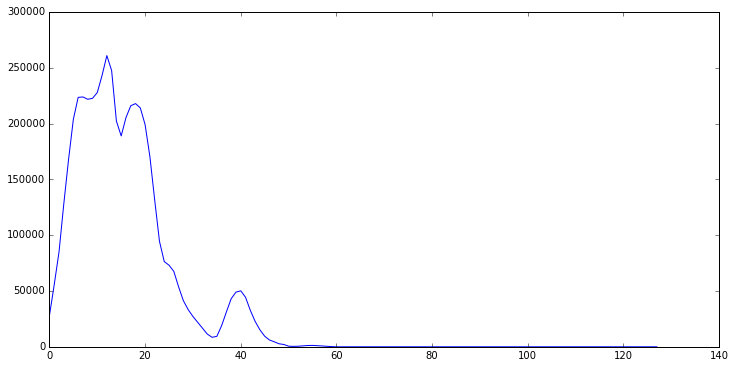

In [99]:
fls = gdir.read_pickle('model_flowlines')
fl = fls[0]
# Now we are going to compute the area of each section (this has to be conserved):
section = 2. / 3 * fl.widths_m * (fl.surface_h - fl.bed_h)
plt.plot(section);

In [51]:
# ok, now make a U shaped bed everywhere 
# where widths are zero - below the current tongue - I set to 30 units (units * fl.map_dx = real width)
bed_h = np.where(fl.widths_m > 0, fl.surface_h - section/fl.widths_m, fl.bed_h)
widths = np.where(fl.widths > 0, fl.widths, 30)
u_fl = flowline.VerticalWallFlowline(line=fl.line, dx=fl.dx, map_dx=fl.map_dx,
                                     surface_h=fl.surface_h, widths=widths,
                                     bed_h=bed_h)
# check
assert np.isclose(u_fl.volume_km3, fl.volume_km3)

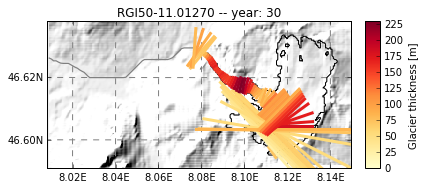

In [52]:
#  See how a bigger glacier looks like
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until_equilibrium()
graphics.plot_modeloutput_map(gdir, model=model)

In [53]:
# we now use the actual Histalp mass balance to run the model on the flat tongue
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a)

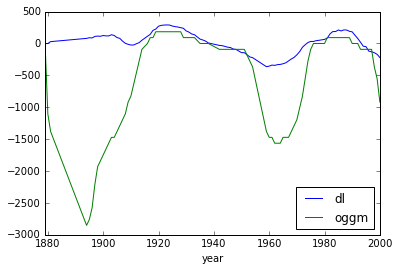

In [54]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();

The tongue retreat is even stronger than with the parabolic bed!